In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from tensorflow.keras import Sequential, optimizers
from tensorflow.keras.layers import Dense

In [4]:
def fill_null_data(feature_data):
    null_count = feature_data.isnull().sum()
    null_columns = null_count[null_count > 0].index
    if len(null_columns):
        feature_data.fillna(
            feature_data[null_columns].mean(),
            inplace=True
        )

In [76]:
house_data = pd.read_csv('kc_house_data.csv')
fill_null_data(house_data)

"""
RAW DATA COLUMNS
-----------------
data.columns = Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                      'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
                      'sqft_living15', 'sqft_lot15'], 
                     dtype='object')
"""

"\nRAW DATA COLUMNS\n-----------------\ndata.columns = Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',\n                      'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',\n                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',\n                      'sqft_living15', 'sqft_lot15'], \n                     dtype='object')\n"

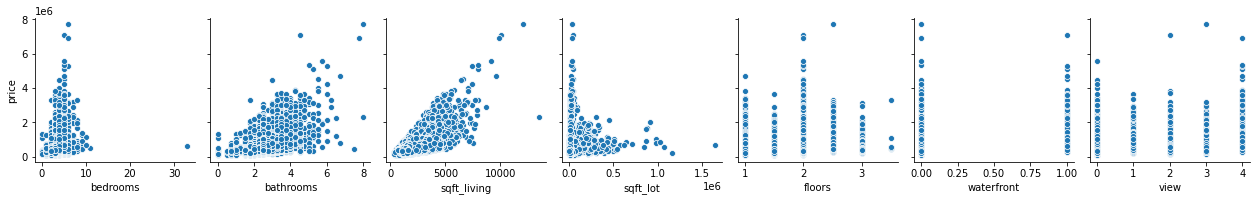

In [92]:
plt.rcParams['figure.figsize']=(10,10)

sns.pairplot(
    house_data,
    y_vars=['price'],
    x_vars=['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
           'floors', 'waterfront', 'view']
    )

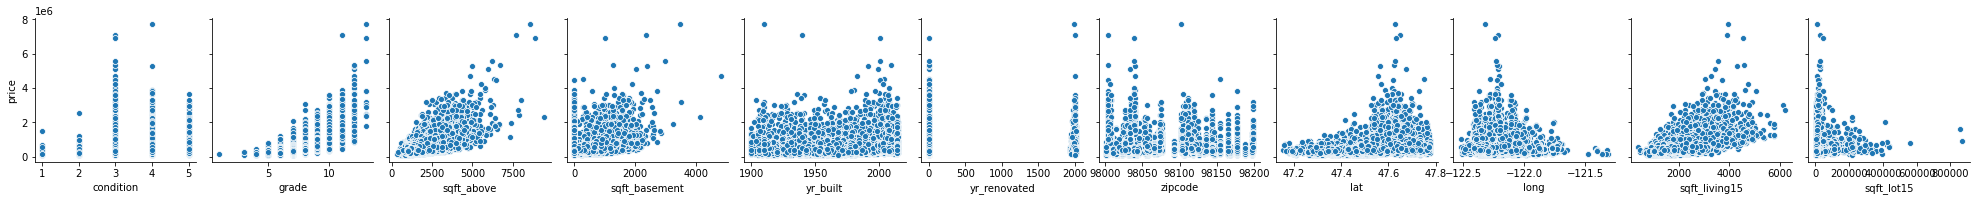

In [93]:
sns.pairplot(
    house_data,
    y_vars=['price'],
    x_vars=['condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
           'sqft_living15', 'sqft_lot15']
    )

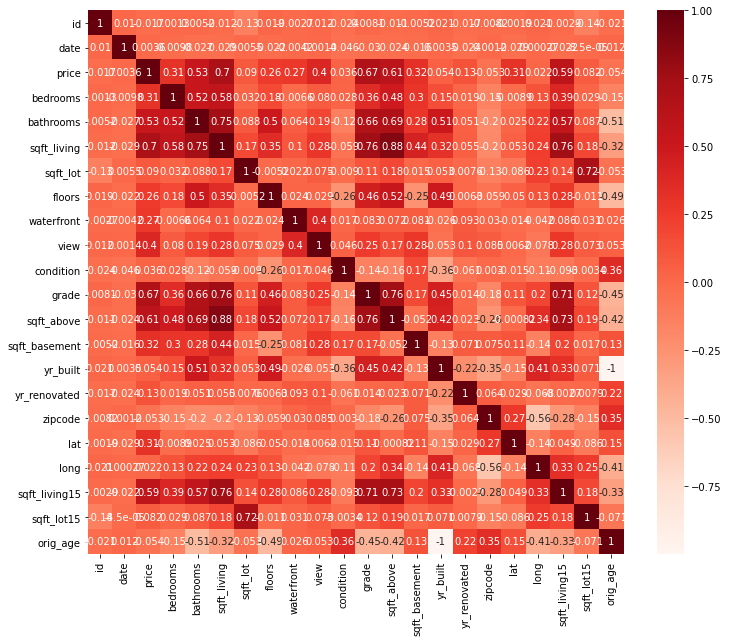

price            1.000000
bathrooms        0.525138
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
Name: price, dtype: float64

In [33]:
# Feature Transformation
house_data['date'] = pd.to_datetime(house_data['date']).dt.year
house_data['orig_age'] = house_data['date'] - house_data['yr_built']

plt.figure(figsize=(12,10))
cor = house_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

cor_target = abs(cor["price"])
cor_target[cor_target>0.4]

In [34]:
# sqft_living highly corr to sqft_living15, sqft_lot highly corr to sqft_lot15
# zipcode, lat, long has less corr with price
# waterfornt, view, yr_renovated has mostly sparse data
# orig_age will take account of sold_date-yr_built

COLUMNS_TO_REMOVE = ['id', 'date', 'yr_built', 'yr_renovated', 'waterfront', 'view', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
house_data.drop(COLUMNS_TO_REMOVE, axis=1, inplace=True)


In [35]:
poly = PolynomialFeatures(2)
transformed_data = poly.fit_transform(house_data.loc[:, house_data.columns[1:]])[:, 1:]
transformed_data = pd.DataFrame(transformed_data)
transformed_data

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,3.0,1.00,1180.0,5650.0,1.0,3.0,7.0,1180.0,0.0,59.0,...,49.0,8260.0,0.0,413.0,1392400.0,0.0,69620.0,0.0,0.0,3481.0
1,3.0,2.25,2570.0,7242.0,2.0,3.0,7.0,2170.0,400.0,63.0,...,49.0,15190.0,2800.0,441.0,4708900.0,868000.0,136710.0,160000.0,25200.0,3969.0
2,2.0,1.00,770.0,10000.0,1.0,3.0,6.0,770.0,0.0,82.0,...,36.0,4620.0,0.0,492.0,592900.0,0.0,63140.0,0.0,0.0,6724.0
3,4.0,3.00,1960.0,5000.0,1.0,5.0,7.0,1050.0,910.0,49.0,...,49.0,7350.0,6370.0,343.0,1102500.0,955500.0,51450.0,828100.0,44590.0,2401.0
4,3.0,2.00,1680.0,8080.0,1.0,3.0,8.0,1680.0,0.0,28.0,...,64.0,13440.0,0.0,224.0,2822400.0,0.0,47040.0,0.0,0.0,784.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3.0,2.50,1530.0,1131.0,3.0,3.0,8.0,1530.0,0.0,5.0,...,64.0,12240.0,0.0,40.0,2340900.0,0.0,7650.0,0.0,0.0,25.0
21609,4.0,2.50,2310.0,5813.0,2.0,3.0,8.0,2310.0,0.0,1.0,...,64.0,18480.0,0.0,8.0,5336100.0,0.0,2310.0,0.0,0.0,1.0
21610,2.0,0.75,1020.0,1350.0,2.0,3.0,7.0,1020.0,0.0,5.0,...,49.0,7140.0,0.0,35.0,1040400.0,0.0,5100.0,0.0,0.0,25.0
21611,3.0,2.50,1600.0,2388.0,2.0,3.0,8.0,1600.0,0.0,11.0,...,64.0,12800.0,0.0,88.0,2560000.0,0.0,17600.0,0.0,0.0,121.0


In [36]:
# Outliers removed on basis of z score
house_data = house_data[(np.abs(stats.zscore(house_data)) < 3).all(axis=1)]

columns_to_normalise = house_data.columns[1:]
scaler = MinMaxScaler()
house_data.loc[:, columns_to_normalise] = scaler.fit_transform(house_data.loc[:, columns_to_normalise])

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,orig_age
0,221900.0,0.4,0.235294,0.182844,0.037291,0.0,0.333333,0.333333,0.207692,0.000000,0.517241
1,538000.0,0.4,0.529412,0.496614,0.048864,0.5,0.333333,0.333333,0.461538,0.248447,0.551724
2,180000.0,0.2,0.235294,0.090293,0.068913,0.0,0.333333,0.166667,0.102564,0.000000,0.715517
3,604000.0,0.6,0.705882,0.358916,0.032566,0.0,1.000000,0.333333,0.174359,0.565217,0.431034
4,510000.0,0.4,0.470588,0.295711,0.054956,0.0,0.333333,0.500000,0.335897,0.000000,0.250000
...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,0.4,0.588235,0.261851,0.004442,1.0,0.333333,0.500000,0.297436,0.000000,0.051724
21609,400000.0,0.6,0.588235,0.437923,0.038476,0.5,0.333333,0.500000,0.497436,0.000000,0.017241
21610,402101.0,0.2,0.176471,0.146727,0.006034,0.5,0.333333,0.333333,0.166667,0.000000,0.051724
21611,400000.0,0.4,0.588235,0.277652,0.013579,0.5,0.333333,0.500000,0.315385,0.000000,0.103448


In [65]:
X_train, X_test, y_train, y_test = train_test_split(house_data, house_data['price'], test_size=0.2)
X_train = X_train.iloc[:, 1:]
X_test = X_test.iloc[:, 1:]
lm = LinearRegression()
reg_model = lm.fit(X_train, y_train)
reg_predictions = lm.predict(X_test)

plt.scatter(y_test, reg_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print(reg_model.score(X_test, y_test))

Train on 16301 samples
Epoch 1/50
16301/16301 [==============================] - 1s 55us/sample - loss: 307091089113.3825 - mae: 496395.3438 - mse: 307090915328.0000
Epoch 2/50
16301/16301 [==============================] - 1s 35us/sample - loss: 305525213380.3698 - mae: 494913.2500 - mse: 305525227520.0000
Epoch 3/50
16301/16301 [==============================] - 1s 35us/sample - loss: 300730788963.5669 - mae: 490352.8438 - mse: 300730810368.0000
Epoch 4/50
16301/16301 [==============================] - 1s 37us/sample - loss: 290922050752.4122 - mae: 480871.5000 - mse: 290922004480.0000
Epoch 5/50
16301/16301 [==============================] - 1s 37us/sample - loss: 274564435658.1805 - mae: 464627.7500 - mse: 274564300800.0000
Epoch 6/50
16301/16301 [==============================] - 1s 35us/sample - loss: 250618934470.4428 - mae: 439795.0938 - mse: 250618888192.0000
Epoch 7/50
16301/16301 [==============================] - 1s 35us/sample - loss: 218799088723.1085 - mae: 404583.7188 -

In [69]:
predictions = cross_val_predict(reg_model, X_train, y_train, cv=5)
plt.scatter(y_train, predictions)
accuracy = metrics.r2_score(y_train, predictions)
accuracy

4076/4076 [==============================] - 0s 10us/sample - loss: 28914091939.5486 - mae: 127398.3594 - mse: 28914089984.0000


127398.36

In [73]:
seq_model = Sequential([
        Dense(32, activation='relu', input_shape=[10, ]),
        Dense(32, activation='relu'),
        Dense(1)
    ])

optimizer = optimizers.RMSprop(0.001)
seq_model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

seq_model.fit(
    X_train,
    y_train,
    epochs=50,
    shuffle=True
)

0.5221965655174574